# Library

## Python packages

In [1]:
import pandas as pd
import numpy as np
import regex as re
import rpy2
import os
import functools as fct
from collections import Counter
import pickle

/Users/tanya/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## R packages 

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(rlang)
library(ggplot2)
library(dplyr)
library(scales)
library(reshape2)
library(cowplot)
library(ape)
library(stringr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘ape’

The following object is masked from ‘package:dplyr’:

    where



## Set path 

In [4]:
path_to_data = '/Users/tanya/Documents/OTT/Conflicts_ClinVar/data'
path_to_vcfs = '/Users/tanya/Documents/OTT/Conflicts_ClinVar/data/vcfs'   # path to initial ClinVar dfs
path_to_gatk = '/Users/tanya/Documents/tools/gatk-4.5.0.0/gatk'
path_to_tables = '/Users/tanya/Documents/OTT/Conflicts_ClinVar/tables'
path_to_plots = '/Users/tanya/Documents/OTT/Conflicts_ClinVar/plots'
path_to_temp = '/Users/tanya/Documents/OTT/Conflicts_ClinVar/temp'

## Load data

In [10]:
vep = pd.read_csv(f'{path_to_tables}/VEP_jn5mod.csv', sep=',')
vep.shape

/var/folders/sy/0s6mz48x25xdw7n08d30rp5w0000gn/T/ipykernel_11871/2434831373.py:1: DtypeWarning: Columns (0,25) have mixed types. Specify dtype option on import or set low_memory=False.
  vep = pd.read_csv(f'{path_to_tables}/VEP_jn5mod.csv', sep=',')


(2296245, 28)

In [11]:
ensembl_ids = pd.read_csv(f'{path_to_data}/features/ensembl_ids.txt', sep='\t')
ensembl_ids.columns = ['ENSEMBL', 'SYMBOL']
ensembl_ids = ensembl_ids.dropna()
ensembl_ids.drop_duplicates(subset=['SYMBOL'])

,ENSEMBL,SYMBOL
0,ENSG00000210049,MT-TF
1,ENSG00000211459,MT-RNR1
2,ENSG00000210077,MT-TV
3,ENSG00000210082,MT-RNR2
4,ENSG00000209082,MT-TL1
...,...,...
70699,ENSG00000282872,C1orf232
70700,ENSG00000236782,ZNF593OS
70701,ENSG00000142684,ZNF593
70702,ENSG00000142675,CNKSR1


In [12]:
hpo_table = pd.read_csv(f'{path_to_data}/features/hpo_table.csv', sep='\t')
hpo_table.columns = ['SYMBOL', 'OMIM', 'INH', 'ENSEMBL']
hpo_table.head(3)

,SYMBOL,OMIM,INH,ENSEMBL
0,A4GALT,OMIM:111400,AD,ENSG00000128274
1,AAAS,OMIM:231550,AR,ENSG00000094914
2,AAGAB,OMIM:148600,AD,ENSG00000103591


In [13]:
%%R

bmrt_mims <- read.csv('./data/features/bioMart_Gene_MIM.txt', sep='\t')
colnames(bmrt_mims) <- c('ENSEMBL', 'SYMBOL', 'MIM_per_GENE')

gene_mim_summary <- na.omit(bmrt_mims) %>%
  group_by(SYMBOL) %>%
  summarise(
    MIM_per_GENE = paste(MIM_per_GENE, collapse = ";"))

gene_mim_summary
write.table(gene_mim_summary, './tables/biomrt_gene_MIM.csv', sep='\t', quote=FALSE)

In [14]:
# bioMart - diseases list

bmrt_mims = pd.read_csv('./data/features/biomrt_gene_MIM.csv', sep=',')
bmrt_mims.columns = ['SYMBOL', 'MIM_per_GENE']

vep = vep.merge(bmrt_mims, on =['SYMBOL'], how='left')
#vep = vep.drop(columns = ['MIM_per_GENE_x', 'MIM_per_GENE_y'])
vep.shape

(2296245, 29)

In [15]:
vep

,CHROM,POS,ID,REF,ALT,SYMBOL,IMPACT,Consequence,MAX_AF,MAX_AF_POPS,...,gnomADg_OTH_AF,gnomADg_SAS_AF,LOCALAFDB_AF_healthy,CLNVC,CLNDISDB,CLNSIG_MASK,INITIAL_CLNSIG,Consequence_MASK,MIN_AF,MIM_per_GENE
0,1,1014063,1354468,T,A,ISG15,MODERATE,missense_variant,6.539e-05,gnomADg_AMR,...,0,0,.,single_nucleotide_variant,"MONDO:MONDO:0014502,MedGen:C4015293,OMIM:61612...",COI,VUS,Missense,0,616126
1,1,1014131,1644340,G,T,ISG15,MODERATE,missense_variant,0.0051,SAS,...,0,0.002894,0.00030432136335970786,single_nucleotide_variant,"MedGen:C3661900|MONDO:MONDO:0014502,MedGen:C40...",COI,LB,Missense,0,616126
2,1,1014138,652606,C,T,ISG15,MODERATE,missense_variant,9.805e-05,gnomADe_SAS,...,0,0,.,single_nucleotide_variant,"MONDO:MONDO:0014502,MedGen:C4015293,OMIM:61612...",COI,VUS,Missense,0,616126
3,1,1014276,568195,G,A,ISG15,MODERATE,missense_variant,0.002871,gnomADg_OTH,...,0.002871,0,.,single_nucleotide_variant,"MeSH:D030342,MedGen:C0950123|MONDO:MONDO:00145...",COI,VUS,Missense,0,616126
4,1,1020239,210112,G,C,AGRN,MODERATE,missense_variant,0.03373,gnomADe_SAS,...,0.009126,0.03081,0.01928374655647383,single_nucleotide_variant,"MedGen:C3661900|.|MONDO:MONDO:0014052,MedGen:C...",COI,COI,Missense,0,615120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2296240,Y,12915726,3044219,C,T,DDX3Y,LOW,synonymous_variant,0.0042,EUR,...,0,0,.,single_nucleotide_variant,.,LB,NaN,Other,0,415000
2296241,Y,12915947,2429752,CTG,C,DDX3Y,HIGH,frameshift_variant,.,.,...,.,.,.,Deletion,"Human_Phenotype_Ontology:HP:0011961,MedGen:C40...",LP,NaN,pLOF,.,415000
2296242,Y,12915989,2429753,A,AT,DDX3Y,HIGH,frameshift_variant,.,.,...,.,.,.,Duplication,"Human_Phenotype_Ontology:HP:0011961,MedGen:C40...",LP,NaN,pLOF,.,415000
2296243,Y,12916632,2429754,TG,T,DDX3Y,HIGH,frameshift_variant&splice_region_variant,.,.,...,.,.,.,Deletion,"Human_Phenotype_Ontology:HP:0011961,MedGen:C40...",LP,NaN,pLOF,.,415000


# Lists of genes

## P1 

### by Symbol 

In [18]:
# genes with COI  (genes with at least one associated MIM)
 
coi_genes_list = vep[vep['CLNSIG_MASK'] == 'COI']['SYMBOL'].unique()
coi_genes_list = [x for x in coi_genes_list if str(x) != 'nan']
len(coi_genes_list)

3703

In [19]:
# genes w/o COI (genes with at least one associated MIM)

nocoi_genes_list = vep[vep['CLNSIG_MASK'] != 'COI']['SYMBOL'].unique()
nocoi_genes_list = [x for x in nocoi_genes_list if str(x) != 'nan']
nocoi_genes_list = [x for x in nocoi_genes_list if x not in coi_genes_list]

len(nocoi_genes_list)

1028

In [23]:
# genes with at least one associated MIM

#mim_genes_df = vep.dropna(subset=['MIM_per_GENE'])
#mim_genes_list = list(mim_genes_df['SYMBOL'].unique())
#len(mim_genes_list)

4719

In [12]:
# genes have at least one P variant

#pathogenic_genes_list = list(vep[vep['CLNSIG_MASK'] == 'P']['SYMBOL'].unique())
#pathogenic_genes_list = [x for x in pathogenic_genes_list if str(x) != 'nan']
#len(pathogenic_genes_list)

4702

In [25]:
# compare filter (by at least one P vs at least one MIM)

#compare = pd.merge(pd.DataFrame(mim_genes_list, columns=['SYMBOL']), pd.DataFrame(pathogenic_genes_list, columns=['SYMBOL']),
#         on=['SYMBOL'],how='outer', indicator=True )

#print('Genes are only in MIM-genes list:', compare[compare['_merge'] == 'right_only'].shape)
#print('Genes are only in P-genes list:', compare[compare['_merge'] == 'left_only'].shape)
#print('Intersected genes:', compare[compare['_merge'] == 'both'].shape)

Genes are only in MIM-genes list: (516, 2)
Genes are only in P-genes list: (533, 2)
Intersected genes: (4186, 2)


In [26]:
#with open("pathogenic_genes_list", "wb") as fp:   #Pickling
#    pickle.dump(pathogenic_genes_list, fp)

In [27]:
#with open("coi_genes_list", "wb") as fp:   #Pickling
#    pickle.dump(coi_genes_list, fp)

In [13]:
# genes with COI and with at least one P

#coi_pgenes_list = vep[vep['CLNSIG_MASK'] == 'COI']['SYMBOL'].unique()

#coi_pgenes_list = [x for x in coi_pgenes_list if x in pathogenic_genes_list]
#coi_pgenes_list = [x for x in coi_pgenes_list if str(x) != 'nan']
#len(coi_pgenes_list)

3627

In [15]:
# genes with no COI and at least one P

#pathogenic_genes_list_nocoi = [x for x in pathogenic_genes_list if x not in coi_pgenes_list]
#len(pathogenic_genes_list_nocoi)

1075

In [30]:
# genes with no COI and at least one associated MIM

#mim_genes_list_nocoi = [x for x in mim_genes_list if x not in coi_genes_list]
#len(mim_genes_list_nocoi)

1025

### Ensembl IDs 

In [20]:
ensembl_ids = pd.read_csv(f'{path_to_data}/features/ensembl_ids.txt', sep='\t')
ensembl_ids.columns = ['ENSEMBL', 'SYMBOL']
ensembl_ids = ensembl_ids.dropna()
ensembl_ids = ensembl_ids.drop_duplicates(subset=['SYMBOL'])
ensembl_ids.head(3)

,ENSEMBL,SYMBOL
0,ENSG00000210049,MT-TF
1,ENSG00000211459,MT-RNR1
2,ENSG00000210077,MT-TV


In [32]:
# genes with at least one associated MIM

#ensmbl_mim_genes_list = pd.merge(pd.DataFrame(mim_genes_list, columns=['SYMBOL']),
                                 ensembl_ids, on=['SYMBOL'], how='inner')

#ensmbl_mim_genes_list = ensmbl_mim_genes_list['ENSEMBL'].to_list()

#len(ensmbl_mim_genes_list)

4719

In [17]:
# genes have at least one P variant

#ensmbl_pathogenic_genes_list = pd.merge(pd.DataFrame(pathogenic_genes_list, columns=['SYMBOL']),
#                                 ensembl_ids, on=['SYMBOL'], how='inner')

#ensmbl_pathogenic_genes_list = ensmbl_pathogenic_genes_list['ENSEMBL'].dropna().to_list()

#len(ensmbl_pathogenic_genes_list)

4660

In [21]:
# all genes with COI 

ensmbl_coi_genes_list = pd.merge(pd.DataFrame(coi_genes_list, columns=['SYMBOL']),
                                 ensembl_ids, on=['SYMBOL'], how='inner')

ensmbl_coi_genes_list = ensmbl_coi_genes_list['ENSEMBL'].dropna().to_list()

len(ensmbl_coi_genes_list)

3703

In [23]:
# genes  with COI  and with at least one P

#ensmbl_coi_pgenes_list = pd.merge(pd.DataFrame(coi_pgenes_list, columns=['SYMBOL']),
#                                 ensembl_ids, on=['SYMBOL'], how='inner')

#ensmbl_coi_pgenes_list = ensmbl_coi_pgenes_list['ENSEMBL'].dropna().to_list()

#len(coi_pgenes_list)

In [24]:
# all genes w/o COI

ensmbl_nocoi_genes_list = pd.merge(pd.DataFrame(nocoi_genes_list, columns=['SYMBOL']),
                                 ensembl_ids, on=['SYMBOL'], how='inner')

ensmbl_nocoi_genes_list = ensmbl_nocoi_genes_list['ENSEMBL'].dropna().to_list()

len(ensmbl_nocoi_genes_list)

1028

In [37]:
# genes with no COI and at least one P

#ensmbl_pathogenic_genes_list_nocoi = pd.merge(pd.DataFrame(pathogenic_genes_list_nocoi, columns=['SYMBOL']),
#                                 ensembl_ids, on=['SYMBOL'], how='inner')

#ensmbl_pathogenic_genes_list_nocoi = ensmbl_pathogenic_genes_list_nocoi['ENSEMBL'].dropna().to_list()

#len(ensmbl_pathogenic_genes_list_nocoi)

1051

In [38]:
# genes with no COI and at least one associated MIM

#ensmbl_mim_genes_list_nocoi = pd.merge(pd.DataFrame(mim_genes_list_nocoi, columns=['SYMBOL']),
#                                 ensembl_ids, on=['SYMBOL'], how='inner')

#ensmbl_mim_genes_list_nocoi = ensmbl_mim_genes_list_nocoi['ENSEMBL'].dropna().to_list()

#len(ensmbl_mim_genes_list_nocoi)

1025

## P2 

In [30]:
# Genes enriched with COI variants

ea_coi_pgenes = pd.read_csv(f'{path_to_temp}/coi_pgenes_ea_flt.csv', sep='\t')
ea_coi_pgenes_list = list(ea_coi_pgenes['gene'].unique())

print(len(ea_coi_pgenes_list))
# Control - pgenes with at least one COI record
# genes  with COI  and with at least one P

coi_pgenes_list = vep[vep['CLNSIG_MASK'] == 'COI']['SYMBOL'].unique()

coi_pgenes_list = [x for x in coi_pgenes_list if x in pathogenic_genes_list]
coi_pgenes_list = [x for x in coi_pgenes_list if str(x) != 'nan']
print(len(coi_pgenes_list))

292
3627


In [31]:
# ENSEMBL

# enriched
ensmbl_ea_coi_pgenes_list = pd.merge(pd.DataFrame(ea_coi_pgenes_list, columns=['SYMBOL']),
                                 ensembl_ids, on=['SYMBOL'], how='inner')

ensmbl_ea_coi_pgenes_list = ensmbl_ea_coi_pgenes_list['SYMBOL'].to_list()

print(len(ensmbl_ea_coi_pgenes_list))


# genes  with COI  and with at least one P

ensmbl_coi_pgenes_list = pd.merge(pd.DataFrame(coi_pgenes_list, columns=['SYMBOL']),
                                 ensembl_ids, on=['SYMBOL'], how='inner')

ensmbl_coi_pgenes_list = ensmbl_coi_pgenes_list['ENSEMBL'].dropna().to_list()

print(len(coi_pgenes_list))

290
3627


# Inheritance

In [25]:
# All genes
# merge groups of genes and calculate inh by category 

coi_genes_inh = pd.DataFrame(coi_genes_list, columns=['SYMBOL']).merge(hpo_table, on=['SYMBOL'], how="left")
coi_genes_inh['FLAG'] = 'COI'

nocoi_genes_inh = pd.DataFrame(nocoi_genes_list, columns=['SYMBOL']).merge(hpo_table, on=['SYMBOL'], how="left")
nocoi_genes_inh['FLAG'] = 'NO_COI'

coi_ncoi_inh_all = pd.concat([coi_genes_inh, nocoi_genes_inh])

In [22]:
# Genes with at least one P
# merge groups of genes and calculate inh by category 

#coi_pgenes_inh = pd.DataFrame(coi_pgenes_list, columns=['SYMBOL']).merge(hpo_table, on=['SYMBOL'], how="left")
#coi_pgenes_inh['FLAG'] = 'COI'

#nocoi_pgenes_inh = pd.DataFrame(pathogenic_genes_list_nocoi, columns=['SYMBOL']).merge(hpo_table, on=['SYMBOL'], how="left")
#nocoi_pgenes_inh['FLAG'] = 'NO_COI'

#coi_ncoi_inh_pgenes = pd.concat([coi_pgenes_inh, nocoi_pgenes_inh])

In [32]:
# Genes enriched with COI
# merge groups of genes and calculate inh by category

ea_coi_pgenes_inh = pd.DataFrame(ea_coi_pgenes_list, columns=['SYMBOL']).merge(hpo_table, on=['SYMBOL'], how="left")
ea_coi_pgenes_inh['FLAG'] = 'E_COI'

coi_pgenes_inh = pd.DataFrame(coi_pgenes_list, columns=['SYMBOL']).merge(hpo_table, on=['SYMBOL'], how="left")
coi_pgenes_inh['FLAG'] = 'COI'

coi_inh_ea = pd.concat([ea_coi_pgenes_inh, coi_pgenes_inh])
coi_inh_ea

,SYMBOL,OMIM,INH,ENSEMBL,FLAG
0,BRCA2,NaN,NaN,NaN,E_COI
1,TTN,OMIM:600334,AD,ENSG00000155657,E_COI
2,TTN,OMIM:603689,AD,ENSG00000155657,E_COI
3,TTN,OMIM:604145,AD,ENSG00000155657,E_COI
4,TTN,OMIM:608807,AR,ENSG00000155657,E_COI
...,...,...,...,...,...
5015,F8,OMIM:306700,XL,ENSG00000185010,COI
5016,RAB39B,OMIM:300271,XL,ENSG00000155961,COI
5017,RAB39B,OMIM:311510,XL,ENSG00000155961,COI
5018,TMLHE,OMIM:300872,XL,ENSG00000185973,COI


In [27]:
%%R -i coi_ncoi_inh_all
#%%R -i coi_inh_ea
#%%R -i coi_ncoi_inh_pgenes



coi_inh_stat <- na.omit(coi_ncoi_inh_all)  %>%
#coi_inh_stat <- na.omit(coi_ncoi_inh_pgenes)  %>%
#coi_inh_stat <- na.omit(coi_inh_ea)  %>%
  group_by(FLAG, INH) %>%
  summarise(count = n() ) %>%
  mutate( prop = count / sum(count))

coi_inh_stat

`summarise()` has grouped output by 'FLAG'. You can override using the
`.groups` argument.


/Users/tanya/anaconda3/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


# A tibble: 9 × 4
# Groups:   FLAG [2]
  FLAG   INH   count    prop
  <chr>  <chr> <int>   <dbl>
1 COI    AD     1775 0.382  
2 COI    ADAR    158 0.0340 
3 COI    AR     2434 0.524  
4 COI    XL      282 0.0607 
5 NO_COI AD      213 0.359  
6 NO_COI ADAR      8 0.0135 
7 NO_COI AR      343 0.578  
8 NO_COI XL       25 0.0422 
9 NO_COI YL        4 0.00675


In [28]:
%%R

write.table(coi_inh_stat, './plots/pgenes_ea_inh.csv', sep=',', quote=FALSE)

In [ ]:
%%R

#  all
coi_ncoi_all <- data.frame(INH=c(rep("AD",2018),rep("ADAR",168),rep("AR",2802), rep("XL",311), rep("YL",4)), 
                  
                  FLAG=c(rep('NO_COI',217), rep('COI',1801), rep('NO_COI',8), rep('COI',160),
                        rep('NO_COI',344), rep('COI',2458), rep('NO_COI',25), rep('COI',286), 
                        rep('NO_COI',4), rep('COI',0)))

table(coi_ncoi_all)
chisq.test(coi_ncoi_all$FLAG, coi_ncoi_all$INH)

In [ ]:
%%R

# coi_ncoi pgenes
#coi_ncoi_p_flt <- data.frame(INH=c(rep("AD",1954),rep("ADAR",165),rep("AR",2772), rep("XL",310), rep("YL",2)), 
                  
#                  FLAG=c(rep('NO_COI',153), rep('COI',1801), rep('NO_COI',5), rep('COI',160),
#                        rep('NO_COI',314), rep('COI',2458), rep('NO_COI',24), rep('COI',286), 
#                        rep('NO_COI',2), rep('COI',0)))

#table(coi_ncoi_p_flt)
#chisq.test(coi_ncoi_p_flt$FLAG, coi_ncoi_p_flt$INH)

In [57]:
%%R

# ea

coi_ea <- data.frame(INH=c(rep("AD",2016),rep("ADAR",181),rep("AR",2635), rep("XL",306)), 
                  
                  FLAG=c(rep('COI',1702), rep('E_COI',314), rep('COI',152), rep('E_COI',29),
                        rep('COI',2405), rep('E_COI',230), rep('COI',281), rep('E_COI',25)))

table(coi_ea)
chisq.test(coi_ea$FLAG, coi_ea$INH)


	Pearson's Chi-squared test

data:  coi_ea$FLAG and coi_ea$INH
X-squared = 59.039, df = 3, p-value = 9.429e-13



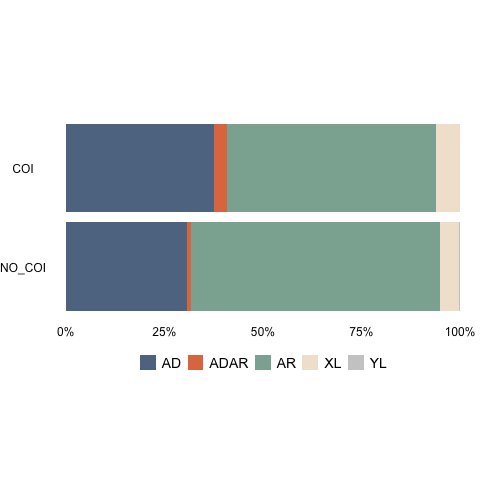

In [25]:
%%R

coi_inh_stat$INH <- factor(coi_inh_stat$INH, levels= c("AD", "ADAR", "AR", "XL", "YL"))

coi_inh_plt <- ggplot(coi_inh_stat, aes(x=FLAG, y=prop, fill=forcats::fct_rev(INH))) + 
  geom_bar(stat='identity') +theme_void() +
  theme(legend.position = "bottom", 
        axis.text=element_text(size=12),
        axis.title=element_text(size=12)) + ylab('') +
  xlab("")  + scale_x_discrete(limits=rev) + scale_y_continuous(labels = percent_format()) +
  scale_fill_manual(values = c( "#cccccc", # for ea
                               "#F1E3D3","#8CAFA1", "#E07A50", "#5e7692"))

coi_inh_plt <- coi_inh_plt + theme(aspect.ratio = 1/2)  + coord_flip() +
guides(fill=guide_legend(title=NULL, nrow=1, byrow=TRUE, reverse=TRUE, label.theme = element_text(size=14)))
coi_inh_plt

#ggsave("./plots/coi_ncoi_inh_all.png")
#ggsave("./plots/coi_ncoi_inh_pgenes.png")
#ggsave("./plots/ecoi_coi_inh_pgenes.png")

# Number of diseases

In [35]:
n_dis = hpo_table[['SYMBOL', 'OMIM']].groupby('SYMBOL').size().to_frame(name='N_DIS').reset_index()
n_dis

,SYMBOL,N_DIS
0,A4GALT,1
1,AAAS,1
2,AAGAB,1
3,AARS1,3
4,AARS2,2
...,...,...
3899,ZP1,1
3900,ZP2,1
3901,ZP3,1
3902,ZSWIM6,2


In [ ]:
# All genes
# merge groups of genes and calculate number of associated diseases by category 

coi_genes_ndis = pd.DataFrame(coi_genes_list, columns=['SYMBOL']).merge(n_dis, on=['SYMBOL'], how="left")
coi_genes_ndis['FLAG'] = 'COI'

nocoi_genes_ndis = pd.DataFrame(nocoi_genes_list, columns=['SYMBOL']).merge(n_dis, on=['SYMBOL'], how="left")
nocoi_genes_ndis['FLAG'] = 'NO_COI'

coi_ncoi_ndis_all = pd.concat([coi_genes_ndis, nocoi_genes_ndis])

In [41]:
# Genes with at least one P (pgenes)
# merge groups of genes and calculate number of associated diseases by category 

coi_pgenes_ndis = pd.DataFrame(coi_pgenes_list, columns=['SYMBOL']).merge(n_dis, on=['SYMBOL'], how="left")
coi_pgenes_ndis['FLAG'] = 'COI'

nocoi_pgenes_ndis = pd.DataFrame(pathogenic_genes_list_nocoi, columns=['SYMBOL']).merge(n_dis, on=['SYMBOL'], how="left")
nocoi_pgenes_ndis['FLAG'] = 'NO_COI'

coi_ncoi_ndis_pgenes = pd.concat([coi_pgenes_ndis, nocoi_pgenes_ndis])

In [44]:
# Genes enriched with COI
# merge groups of genes and calculate inh by category

ea_coi_pgenes_ndis = pd.DataFrame(ea_coi_pgenes_list, columns=['SYMBOL']).merge(n_dis, on=['SYMBOL'], how="left")
ea_coi_pgenes_ndis['FLAG'] = 'E_COI'

coi_pgenes_ndis = pd.DataFrame(coi_pgenes_list, columns=['SYMBOL']).merge(n_dis, on=['SYMBOL'], how="left")
coi_pgenes_ndis['FLAG'] = 'COI'

coi_ncoi_ndis_ea = pd.concat([ea_coi_pgenes_ndis, coi_pgenes_ndis])

In [45]:
%%R -i coi_ncoi_ndis_ea
#%%R -i coi_ncoi_ndis_pgenes

#%%R -i coi_ncoi_ndis_all




#coi_ncoi_ndis_stat <- coi_ncoi_ndis_all  %>%
#coi_ncoi_ndis_stat <- coi_ncoi_ndis_pgenes  %>%
coi_ncoi_ndis_stat <- coi_ncoi_ndis_ea  %>%
  group_by(FLAG, N_DIS) %>%
  summarise(count = n() ) %>%
  mutate( prop = count / sum(count))

coi_ncoi_ndis_stat

`summarise()` has grouped output by 'FLAG'. You can override using the
`.groups` argument.
# A tibble: 22 × 4
# Groups:   FLAG [2]
   FLAG  N_DIS count     prop
   <chr> <dbl> <int>    <dbl>
 1 COI       1  2267 0.625   
 2 COI       2   580 0.160   
 3 COI       3   189 0.0521  
 4 COI       4    64 0.0176  
 5 COI       5    25 0.00689 
 6 COI       6    11 0.00303 
 7 COI       7     7 0.00193 
 8 COI       8     4 0.00110 
 9 COI       9     1 0.000276
10 COI      11     1 0.000276
# ℹ 12 more rows
# ℹ Use `print(n = ...)` to see more rows


/Users/tanya/anaconda3/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


In [47]:
%%R
write.table(coi_ncoi_ndis_stat, './plots/coi_ncoi_ndis_ea.csv', sep=',', quote=FALSE)

In [66]:
%%R

# All genes
#wilcox.test(coi_ncoi_ndis_all$N_DIS[coi_ncoi_ndis_all$FLAG == 'NO_COI'], coi_ncoi_ndis_all$N_DIS[coi_ncoi_ndis_all$FLAG == 'COI'])

# P genes
#wilcox.test(coi_ncoi_ndis_pgenes$N_DIS[coi_ncoi_ndis_pgenes$FLAG == 'NO_COI'], coi_ncoi_ndis_pgenes$N_DIS[coi_ncoi_ndis_pgenes$FLAG == 'COI'])

# COI enriched P genes
wilcox.test(coi_ncoi_ndis_ea$N_DIS[coi_ncoi_ndis_ea$FLAG == 'COI'], coi_ncoi_ndis_ea$N_DIS[coi_ncoi_ndis_ea$FLAG == 'Enr_COI'])


	Wilcoxon rank sum test with continuity correction

data:  coi_ncoi_ndis_ea$N_DIS[coi_ncoi_ndis_ea$FLAG == "COI"] and coi_ncoi_ndis_ea$N_DIS[coi_ncoi_ndis_ea$FLAG == "Enr_COI"]
W = 266178, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`). 



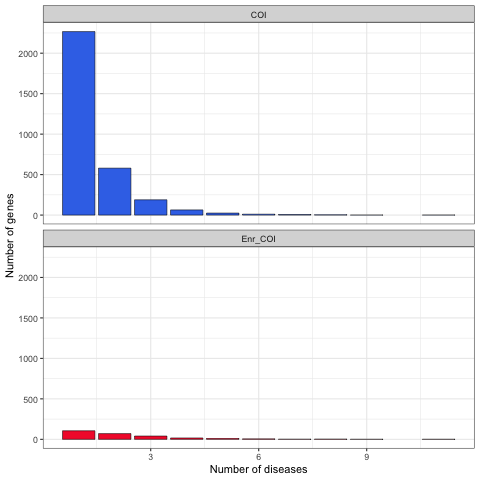

In [39]:
%%R

n_genes <- ggplot(coi_ncoi_ndis_stat, aes(x=N_DIS, y=count, fill=FLAG)) + 
  geom_bar(stat='identity', linewidth=0.25, color='black') +
  xlab('Number of diseases') + ylab('Number of genes')  + scale_fill_manual(values=c("#3B75E9","#F32737"))
#+ scale_fill_manual(values=c("#833B49", "#256C68")) 


n_genes <- n_genes + 
  theme(axis.text=element_text(size=12, color='black'), 
        axis.title= element_text(size=14, color='black'), text=element_text(family='Helvetica'),
        axis.title.y = element_text(angle=90))

n_genes <- n_genes + 
  theme(axis.text=element_text(size=12, color='black'), 
        axis.title= element_text(size=14, color='black'),
        text=element_text(family='Helvetica'), 
        plot.margin = margin(0.5,1,0.5,1,"cm")) 
n_genes <- n_genes + facet_wrap(~FLAG,nrow=2) + theme_bw()  + theme(legend.position="none")
n_genes

#ggsave("./plots/coi_ncoi_ndis_all.png")
#ggsave("coi_ncoi_ndis_pgenes.png")
#ggsave("ecoi_coi_ndis_pgenes.png")

# Constraint Metrics

In [ ]:
! wget https://storage.googleapis.com/gcp-public-data--gnomad/release/2.1.1/constraint/gnomad.v2.1.1.lof_metrics.by_gene.txt.bgz
    
! gunzip -c  gnomad.v2.1.1.lof_metrics.by_gene.txt.bgz  | cut -f1,21,30,36 > ./data/gnomad.v2.1.1.pli_loeuf.txt

In [83]:
# pLI & loeuf data from gnomAD

gnomad = pd.read_csv('./data/features/gnomad.v2.1.1.pli_loeuf.txt', sep='\t')
gnomad.columns = ['SYMBOL', 'pLI', 'oe_lof_upper', 'oe_lof_upper_bin']
gnomad.head(2)

,SYMBOL,pLI,oe_lof_upper,oe_lof_upper_bin
0,MED13,1.0,0.030,0.0
1,NIPBL,1.0,0.032,0.0


In [84]:
# All genes
# merge groups of genes and calculate inh by category 

coi_genes_cstr = pd.DataFrame(coi_genes_list, columns=['SYMBOL']).merge(gnomad, on=['SYMBOL'], how="left")
coi_genes_cstr['FLAG'] = 'COI'

nocoi_genes_cstr = pd.DataFrame(nocoi_genes_list, columns=['SYMBOL']).merge(gnomad, on=['SYMBOL'], how="left")
nocoi_genes_cstr['FLAG'] = 'NO_COI'

coi_ncoi_cstr_all = pd.concat([coi_genes_cstr, nocoi_genes_cstr])


NameError: name 'coi_genes_list' is not defined

In [96]:
# P genes

coi_pgenes_cstr = pd.DataFrame(coi_pgenes_list, columns=['SYMBOL']).merge(gnomad, on=['SYMBOL'], how="left")
coi_pgenes_cstr['FLAG'] = 'COI'

nocoi_pgenes_cstr = pd.DataFrame(pathogenic_genes_list_nocoi, columns=['SYMBOL']).merge(gnomad, on=['SYMBOL'], how="left")
nocoi_pgenes_cstr['FLAG'] = 'NO_COI'

coi_ncoi_cstr_pgenes = pd.concat([coi_pgenes_cstr,nocoi_pgenes_cstr])

In [89]:
# COI enriched genes

ea_coi_pgenes_cstr = pd.DataFrame(ea_coi_pgenes_list, columns=['SYMBOL']).merge(gnomad, on=['SYMBOL'], how="left")
ea_coi_pgenes_cstr['FLAG'] = 'E_COI'

coi_pgenes_cstr = pd.DataFrame(coi_pgenes_list, columns=['SYMBOL']).merge(gnomad, on=['SYMBOL'], how="left")
coi_pgenes_cstr['FLAG'] = 'COI'

coi_coi_cstr_ea = pd.concat([ea_coi_pgenes_cstr, coi_pgenes_cstr])

###  pLI

In [87]:
%%R -i coi_coi_cstr_ea
#%%R -i coi_ncoi_cstr_pgenes
#%%R -i coi_ncoi_cstr_all




# classify pLI value 

#coi_ncoi_cstr_all$pLI <- as.character(coi_ncoi_cstr_all$pLI)
#coi_ncoi_cstr_all$pLI <- as.numeric(coi_ncoi_cstr_all$pLI)

#coi_ncoi_cstr_pgenes$pLI <- as.character(coi_ncoi_cstr_pgenes$pLI)
#coi_ncoi_cstr_pgenes$pLI <- as.numeric(coi_ncoi_cstr_pgenes$pLI)

coi_coi_cstr_ea$pLI <- as.character(coi_coi_cstr_ea$pLI)
coi_coi_cstr_ea$pLI <- as.numeric(coi_coi_cstr_ea$pLI)

#coi_ncoi_pli_stat <- coi_ncoi_cstr_all %>% 
#coi_ncoi_pli_stat <- coi_ncoi_cstr_pgenes %>%
coi_ncoi_pli_stat <- coi_coi_cstr_ea %>%
  mutate(class = case_when(
    pLI <= 0.1 ~ 'pLOF tolerant (pLI <=0.1)',
    pLI >= 0.9 ~ 'pLOF intolerant (pLI >=0.9)',
    pLI > 0.1 & pLI < 0.9 ~ 'intermediate tolerance'))

# count
coi_ncoi_pli_stat <- na.omit(coi_ncoi_pli_stat) %>%
  group_by(FLAG, class) %>%
  summarize(count = n()) %>%
  mutate(prop = (count/sum(count)))


coi_ncoi_pli_stat

`summarise()` has grouped output by 'FLAG'. You can override using the
`.groups` argument.
# A tibble: 6 × 4
# Groups:   FLAG [2]
  FLAG    class                       count  prop
  <chr>   <chr>                       <int> <dbl>
1 COI     intermediate tolerance        448 0.129
2 COI     pLOF intolerant (pLI >=0.9)   879 0.252
3 COI     pLOF tolerant (pLI <=0.1)    2155 0.619
4 Enr_COI intermediate tolerance         31 0.108
5 Enr_COI pLOF intolerant (pLI >=0.9)    70 0.245
6 Enr_COI pLOF tolerant (pLI <=0.1)     185 0.647


/Users/tanya/anaconda3/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


In [ ]:
%%R

coi_ncoi_pli_all <- data.frame(pli=c(rep("InTol",2924),rep("Tol",11262)), 
                  
                  FLAG=c(rep('NO_COI',285), rep('COI',1040), rep('NO_COI',8602), rep('COI',2660)))

table(coi_ncoi_pli_all)
chisq.test(coi_ncoi_pli_all $FLAG, coi_ncoi_pli_all $pli)

In [ ]:
%%R

coi_ncoi_pli_pgenes <- data.frame(pli=c(rep("InTol",1261),rep("Tol",3187)), 
                  
                  FLAG=c(rep('NO_COI',221), rep('COI',1040), rep('NO_COI',527), rep('COI',2660)))

table(coi_ncoi_pli_pgenes)
chisq.test(coi_ncoi_pli_pgenes$FLAG, coi_ncoi_pli_pgenes$pli)

In [75]:
%%R

coi_coi_cstr_ea <- data.frame(pli=c(rep("InTol",949),rep("Tol",2340)), 
                  
                  FLAG=c(rep('COI',879), rep('E_COI',70), rep('COI',2155), rep('E_COI',185)))

table(coi_coi_cstr_ea)
chisq.test(coi_coi_cstr_ea$FLAG, coi_coi_cstr_ea$pli)


	Pearson's Chi-squared test with Yates' continuity correction

data:  coi_coi_cstr_ea$FLAG and coi_coi_cstr_ea$pli
X-squared = 0.19608, df = 1, p-value = 0.6579



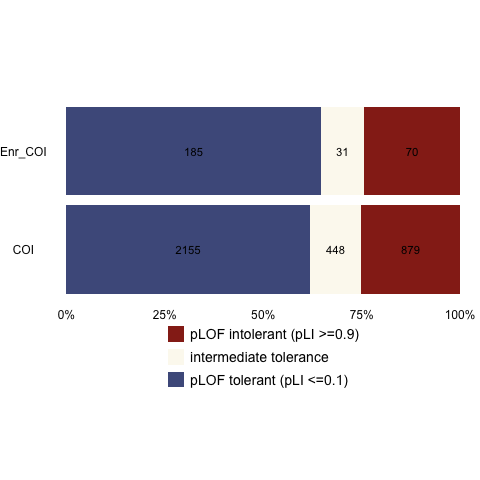

In [76]:
%%R


coi_ncoi_pli_stat$class <- factor(coi_ncoi_pli_stat$class, levels=c("pLOF intolerant (pLI >=0.9)",
                                                           "intermediate tolerance",
                                                           "pLOF tolerant (pLI <=0.1)"))


coi_ncoi_pli_plt <- ggplot(na.omit(coi_ncoi_pli_stat), aes(y=prop, x=FLAG, fill=class, label=count)) +
    geom_bar(position="stack", stat="identity")+ theme_void() + theme(axis.text = element_text(size = 12),
                       axis.title =  element_text(size=14),
                       legend.text=element_text(size=14)) + 
    xlab('') +  ylab(NULL) + 
    scale_y_continuous(labels = percent_format())

coi_ncoi_pli_plt <- coi_ncoi_pli_plt + guides(fill=guide_legend(title=NULL, nrow=3, byrow=TRUE)) + theme(legend.position="bottom") +
                            scale_fill_manual(values=c('#96281B','#fcf9f0','#4e5b8b'))+ geom_text(size = 4, position = position_stack(vjust = 0.5))
coi_ncoi_pli_plt <- coi_ncoi_pli_plt + theme(aspect.ratio = 1/2)  + coord_flip() 
coi_ncoi_pli_plt

#ggsave("./plots/coi_ncoi_pli_all.png")
#ggsave("./plots/coi_ncoi_pli_pgenes.png")
#ggsave("./plots/coi_coi_pli_ea.png")

### LOEUF 

In [98]:
%%R -i coi_coi_cstr_ea
#%%R -i coi_ncoi_cstr_pgenes


#%%R -i coi_ncoi_cstr_all


# count
#coi_ncoi_loeuf_dec <- na.omit(coi_ncoi_cstr_all)%>%
#coi_ncoi_loeuf_dec <- na.omit(coi_ncoi_cstr_pgenes)%>%
coi_ncoi_loeuf_dec <- na.omit(coi_coi_cstr_ea)%>%
  group_by(FLAG, oe_lof_upper_bin) %>%
  summarize(count = n()) %>%
  mutate(prop = (count/sum(count)))

coi_ncoi_loeuf_dec

write.table(coi_ncoi_loeuf_dec, './plots/coi_ncoi_loeuf_ea.csv', sep=',', quote=FALSE)

`summarise()` has grouped output by 'FLAG'. You can override using the
`.groups` argument.


In [78]:
%%R

# All
#wilcox.test(coi_ncoi_cstr_all$oe_lof_upper_bin[coi_ncoi_cstr_all$FLAG == 'NO_COI'], coi_ncoi_cstr_all$oe_lof_upper_bin[coi_ncoi_cstr_all$FLAG == 'COI'])

# P genes
#wilcox.test(coi_ncoi_cstr_pgenes$oe_lof_upper_bin[coi_ncoi_cstr_pgenes$FLAG == 'NO_COI'], coi_ncoi_cstr_pgenes$oe_lof_upper_bin[coi_ncoi_cstr_pgenes$FLAG == 'COI'])

# COI enriched
wilcox.test(coi_coi_cstr_ea$oe_lof_upper_bin[coi_coi_cstr_ea$FLAG == 'COI'], coi_coi_cstr_ea$oe_lof_upper_bin[coi_coi_cstr_ea$FLAG == 'Enr_COI'])


	Wilcoxon rank sum test with continuity correction

data:  coi_coi_cstr_ea$oe_lof_upper_bin[coi_coi_cstr_ea$FLAG == "COI"] and coi_coi_cstr_ea$oe_lof_upper_bin[coi_coi_cstr_ea$FLAG == "Enr_COI"]
W = 500221, p-value = 0.896
alternative hypothesis: true location shift is not equal to 0



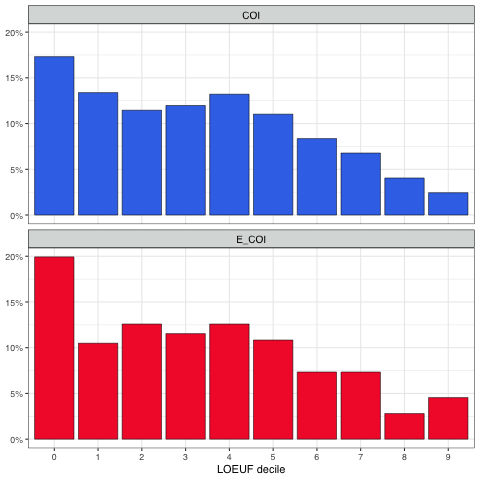

In [91]:
%%R


coi_ncoi_loeuf_dec_plt <- ggplot(coi_ncoi_loeuf_dec, aes(x=as.factor(oe_lof_upper_bin),
                                                         y=prop, fill=FLAG)) + 
  geom_bar(position="stack",
           stat="identity",
           color='black', 
           linewidth=0.25)+
  theme(axis.text = element_text(size = 8),
        axis.title =  element_text(size=10, color='black'), 
        legend.position = "none",
        legend.text=element_text(size=8, color='black'),
        plot.margin = margin(0.5,1,0.5,1,"cm")) + 
  xlab('LOEUF decile') + scale_fill_manual(values=c("#3B75E9","#F32737")) + #+ scale_fill_manual(values=c("#833B49", "#256C68")) +
  ylab(NULL) + scale_y_continuous(labels = percent_format())   + theme_bw()


coi_ncoi_loeuf_dec_plt <- coi_ncoi_loeuf_dec_plt + facet_wrap(. ~ FLAG, nrow=2) +
  theme(strip.text.x = element_text(size = 10),
        text=element_text(family='Helvetica'),
        strip.background =element_rect(fill="#D9DDDC", color = "black"),
        strip.text = element_text(colour = 'black'), legend.position = "none")

coi_ncoi_loeuf_dec_plt

#ggsave("./plots/coi_ncoi_loeuf_dec_all.png")
#ggsave("./plots/coi_ncoi_loeuf_dec_pgenes.png")
#ggsave("./plots/coi_ncoi_loeuf_dec_ea.png")

# GTEx

In [61]:
tx_medians = pd.read_csv(f'{path_to_data}/features/GTEx.V8.tx_medians.021620.csv', sep='\t')
print(tx_medians.shape)
tx_medians.head(3)

(199324, 56)


,ADPSBQ,ADPVSC,ADRNLG,ARTAORT,ARTCRN,ARTTBL,BLDDER,BRNAMY,BRNACC,BRNCDT,...,SNTTRM,SPLEEN,STMACH,TESTIS,THYROID,UTERUS,VAGINA,WHLBLD,transcript_id,gene_id
0,95.78,82.85,74.265,101.550,98.41,98.90,90.84,83.945,113.950,104.300,...,83.64,96.68,78.87,107.30,93.28,114.550,117.250,55.01,ENST00000000233,ENSG00000004059
1,30.75,27.57,30.230,33.615,31.00,34.92,39.77,7.995,9.580,12.405,...,28.12,39.97,17.07,37.39,33.54,35.550,25.450,9.25,ENST00000000412,ENSG00000003056
2,16.81,16.82,19.080,12.005,14.22,13.12,24.44,8.230,10.955,11.185,...,33.11,19.41,23.70,5.30,21.17,9.745,19.225,6.62,ENST00000000442,ENSG00000173153


In [62]:
ensembl_ids = pd.read_csv(f'{path_to_data}/features/ensembl_ids.txt', sep='\t')
ensembl_ids.columns = ['gene_id', 'SYMBOL']
tx_medians = tx_medians.merge(ensembl_ids, on=['gene_id'], how="left")
tx_medians.head(3)

,ADPSBQ,ADPVSC,ADRNLG,ARTAORT,ARTCRN,ARTTBL,BLDDER,BRNAMY,BRNACC,BRNCDT,...,SPLEEN,STMACH,TESTIS,THYROID,UTERUS,VAGINA,WHLBLD,transcript_id,gene_id,SYMBOL
0,95.78,82.85,74.265,101.550,98.41,98.90,90.84,83.945,113.950,104.300,...,96.68,78.87,107.30,93.28,114.550,117.250,55.01,ENST00000000233,ENSG00000004059,ARF5
1,30.75,27.57,30.230,33.615,31.00,34.92,39.77,7.995,9.580,12.405,...,39.97,17.07,37.39,33.54,35.550,25.450,9.25,ENST00000000412,ENSG00000003056,M6PR
2,16.81,16.82,19.080,12.005,14.22,13.12,24.44,8.230,10.955,11.185,...,19.41,23.70,5.30,21.17,9.745,19.225,6.62,ENST00000000442,ENSG00000173153,ESRRA


In [63]:
cols = tx_medians.columns.tolist()
cols = cols[-1:] + cols[:-1]
cols = cols[-1:] + cols[:-1]
cols = cols[-1:] + cols[:-1]
tx_medians = tx_medians[cols]
tx_medians.head()

,transcript_id,gene_id,SYMBOL,ADPSBQ,ADPVSC,ADRNLG,ARTAORT,ARTCRN,ARTTBL,BLDDER,...,SKINNS,SKINS,SNTTRM,SPLEEN,STMACH,TESTIS,THYROID,UTERUS,VAGINA,WHLBLD
0,ENST00000000233,ENSG00000004059,ARF5,95.78,82.85,74.265,101.550,98.41,98.90,90.84,...,166.500,179.80,83.64,96.68,78.87,107.30,93.28,114.550,117.250,55.01
1,ENST00000000412,ENSG00000003056,M6PR,30.75,27.57,30.230,33.615,31.00,34.92,39.77,...,21.145,23.32,28.12,39.97,17.07,37.39,33.54,35.550,25.450,9.25
2,ENST00000000442,ENSG00000173153,ESRRA,16.81,16.82,19.080,12.005,14.22,13.12,24.44,...,20.895,22.71,33.11,19.41,23.70,5.30,21.17,9.745,19.225,6.62
3,ENST00000001008,ENSG00000004478,FKBP4,15.62,21.32,24.325,25.020,24.47,32.21,33.98,...,38.315,37.11,17.45,15.78,30.32,57.79,35.03,25.660,38.750,5.04
4,ENST00000001146,ENSG00000003137,CYP26B1,9.26,6.61,1.050,2.675,2.14,1.46,1.25,...,10.450,13.43,1.42,0.69,0.19,5.43,7.88,1.655,1.920,0.00


In [64]:
# check if any value in a row is bigger than 5

def check_row(row):
    row_to_filter = row[3:]
    return any(row_to_filter > 5)

# Apply the function to each row and filter the DataFrame
tx_medians_flt = tx_medians[tx_medians.apply(check_row, axis=1)]


print(tx_medians_flt.shape)
print(tx_medians.shape)

tx_medians_flt.head()

(53659, 57)
(199324, 57)


,transcript_id,gene_id,SYMBOL,ADPSBQ,ADPVSC,ADRNLG,ARTAORT,ARTCRN,ARTTBL,BLDDER,...,SKINNS,SKINS,SNTTRM,SPLEEN,STMACH,TESTIS,THYROID,UTERUS,VAGINA,WHLBLD
0,ENST00000000233,ENSG00000004059,ARF5,95.78,82.85,74.265,101.550,98.41,98.90,90.84,...,166.500,179.80,83.64,96.68,78.87,107.30,93.28,114.550,117.250,55.01
1,ENST00000000412,ENSG00000003056,M6PR,30.75,27.57,30.230,33.615,31.00,34.92,39.77,...,21.145,23.32,28.12,39.97,17.07,37.39,33.54,35.550,25.450,9.25
2,ENST00000000442,ENSG00000173153,ESRRA,16.81,16.82,19.080,12.005,14.22,13.12,24.44,...,20.895,22.71,33.11,19.41,23.70,5.30,21.17,9.745,19.225,6.62
3,ENST00000001008,ENSG00000004478,FKBP4,15.62,21.32,24.325,25.020,24.47,32.21,33.98,...,38.315,37.11,17.45,15.78,30.32,57.79,35.03,25.660,38.750,5.04
4,ENST00000001146,ENSG00000003137,CYP26B1,9.26,6.61,1.050,2.675,2.14,1.46,1.25,...,10.450,13.43,1.42,0.69,0.19,5.43,7.88,1.655,1.920,0.00


In [65]:
gene_tx_flt = tx_medians_flt[['SYMBOL', 'transcript_id']]
tx_medians_flt_per_gene= gene_tx_flt.groupby(['SYMBOL']).size().reset_index(name = 'tx_per_gene')
tx_medians_flt_per_gene.head()

,SYMBOL,tx_per_gene
0,5_8S_rRNA,1
1,A1BG,4
2,A1CF,2
3,A2M,5
4,A2M-AS1,1


In [ ]:
# ALl

tx_medians_coi = tx_medians_flt_per_gene[tx_medians_flt_per_gene['SYMBOL'].isin(coi_genes_list)]
tx_medians_coi['FLAG'] = 'COI'
print(tx_medians_coi.shape)

tx_medians_no_coi = tx_medians_flt_per_gene[tx_medians_flt_per_gene['SYMBOL'].isin(nocoi_genes_list)]
tx_medians_no_coi['FLAG'] = 'NO_COI'
print(tx_medians_no_coi.shape)

tx_medians_concat_all = pd.concat([tx_medians_coi, tx_medians_no_coi])

In [ ]:
# P genes

tx_medians_coi_pgenes = tx_medians_flt_per_gene[tx_medians_flt_per_gene['SYMBOL'].isin(coi_pgenes_list)]
tx_medians_coi_pgenes['FLAG'] = 'COI'
print(tx_medians_coi_pgenes.shape)

tx_medians_ncoi_pgenes = tx_medians_flt_per_gene[tx_medians_flt_per_gene['SYMBOL'].isin(pathogenic_genes_list_nocoi)]
tx_medians_ncoi_pgenes['FLAG'] = 'NO_COI'
print(tx_medians_ncoi_pgenes .shape)


tx_medians_concat_pgenes = pd.concat([tx_medians_coi_pgenes,tx_medians_ncoi_pgenes])

In [86]:
# Enriched !!!!!!!!

tx_medians_ecoi = tx_medians_flt_per_gene[tx_medians_flt_per_gene['SYMBOL'].isin(ea_coi_pgenes_list)]
tx_medians_ecoi['FLAG'] = 'Enr_COI'
print(tx_medians_ecoi.shape)

tx_medians_coi_pgenes = tx_medians_flt_per_gene[tx_medians_flt_per_gene['SYMBOL'].isin(coi_pgenes_list)]
tx_medians_coi_pgenes['FLAG'] = 'COI'
print(tx_medians_coi_pgenes.shape)


tx_medians_concat_ea = pd.concat([tx_medians_ecoi, tx_medians_coi_pgenes])

(271, 3)
(3286, 3)


/var/folders/sy/0s6mz48x25xdw7n08d30rp5w0000gn/T/ipykernel_62541/3580737994.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_medians_ecoi['FLAG'] = 'Enr_COI'
/var/folders/sy/0s6mz48x25xdw7n08d30rp5w0000gn/T/ipykernel_62541/3580737994.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_medians_coi_pgenes['FLAG'] = 'COI'


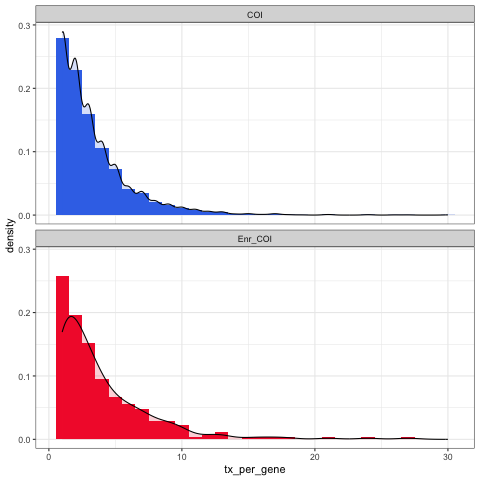

In [88]:
%%R -i tx_medians_concat_ea
#%%R -i tx_medians_concat_pgenes
#%%R -i tx_medians_concat_all




ggplot(
    #tx_medians_concat_all,
    #tx_medians_concat_pgenes,
    tx_medians_concat_ea,
       aes(x=tx_per_gene, fill=FLAG)) + 
geom_histogram(aes(y=..density..),binwidth=1) + 
geom_density(alpha=.2) + facet_wrap(~FLAG,nrow=3) + scale_fill_manual(values=c("#3B75E9","#F32737"))+ #scale_fill_manual(values=c("#833B49", "#256C68")) +
theme_bw()+ theme(legend.position = "none")

#ggsave("./plots/tx_medians_all.png")
#ggsave("tx_medians_pgenes.png")
#ggsave("tx_medians_ea.png")

In [90]:
%%R

# COI - non COI
#wilcox.test(tx_medians_concat_all$tx_per_gene[tx_medians_concat_all$FLAG == 'NO_COI'], tx_medians_concat_all$tx_per_gene[tx_medians_concat_all$FLAG == 'COI'], alternative="less")

# COI - only genes with P and w/o COI
#wilcox.test(tx_medians_concat_pgenes$tx_per_gene[tx_medians_concat_pgenes$FLAG == 'NO_COI'], tx_medians_concat_pgenes$tx_per_gene[tx_medians_concat_pgenes$FLAG == 'COI'], alternative="less")

# COI enriched
wilcox.test(tx_medians_concat_ea$tx_per_gene[tx_medians_concat_ea$FLAG == 'COI'], tx_medians_concat_ea$tx_per_gene[tx_medians_concat_ea$FLAG == 'Enr_COI'], alternative="less")


	Wilcoxon rank sum test with continuity correction

data:  tx_medians_concat_ea$tx_per_gene[tx_medians_concat_ea$FLAG == "COI"] and tx_medians_concat_ea$tx_per_gene[tx_medians_concat_ea$FLAG == "Enr_COI"]
W = 408742, p-value = 0.01096
alternative hypothesis: true location shift is less than 0



In [ ]:
tx_medians.head(2)

In [ ]:
tx_medians[['transcript_id', 'SYMBOL']].to_csv(f'{path_to_temp}/tr_gene.csv', sep='\t', index=False)
tr_symbol_tbl = tx_medians[['transcript_id', 'SYMBOL']]

# Transcript length

In [48]:
biomrt_tr_len = pd.read_csv('./data/features/bioMart_TranscriptLength.txt', sep='\t')
biomrt_tr_len.columns = ['GeneID', 'TrID', 'EnCanonical', 'Tr_length_inclUTRCDS', 'SYMBOL']
biomrt_can_tr_len = biomrt_tr_len[biomrt_tr_len['EnCanonical'] == 1]
biomrt_can_tr_len.head(3)

,GeneID,TrID,EnCanonical,Tr_length_inclUTRCDS,SYMBOL
0,ENSG00000210049,ENST00000387314,1.0,71,MT-TF
1,ENSG00000211459,ENST00000389680,1.0,954,MT-RNR1
2,ENSG00000210077,ENST00000387342,1.0,69,MT-TV


In [ ]:
# All genes

coi_genes_tr = biomrt_can_tr_len[biomrt_tr_len['SYMBOL'].isin(coi_genes_list)]
coi_genes_tr['FLAG'] = 'COI'
print(coi_pgenes_tr.shape)  

nocoi_genes_tr = biomrt_can_tr_len[biomrt_tr_len['SYMBOL'].isin(nocoi_genes_list)]
nocoi_genes_tr['FLAG'] = 'NO_COI'
print(nocoi_genes_tr.shape)

# concat
genes_tr_len = pd.concat([coi_genes_tr,nocoi_genes_tr])

In [53]:
# P genes

coi_pgenes_tr = biomrt_can_tr_len[biomrt_tr_len['SYMBOL'].isin(coi_pgenes_list)]
coi_pgenes_tr['FLAG'] = 'COI'
print(coi_pgenes_tr.shape)  

nocoi_pgenes_tr = biomrt_can_tr_len[biomrt_tr_len['SYMBOL'].isin(pathogenic_genes_list_nocoi)]
nocoi_pgenes_tr['FLAG'] = 'NO_COI'
print(nocoi_pgenes_tr.shape)

# concat
genes_tr_len = pd.concat([coi_pgenes_tr,nocoi_pgenes_tr])

(3961, 6)
(1185, 6)


/var/folders/sy/0s6mz48x25xdw7n08d30rp5w0000gn/T/ipykernel_7699/3736815125.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  coi_pgenes_tr = biomrt_can_tr_len[biomrt_tr_len['SYMBOL'].isin(coi_pgenes_list)]
/var/folders/sy/0s6mz48x25xdw7n08d30rp5w0000gn/T/ipykernel_7699/3736815125.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coi_pgenes_tr['FLAG'] = 'COI'
/var/folders/sy/0s6mz48x25xdw7n08d30rp5w0000gn/T/ipykernel_7699/3736815125.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  nocoi_pgenes_tr = biomrt_can_tr_len[biomrt_tr_len['SYMBOL'].isin(pathogenic_genes_list_nocoi)]
/var/folders/sy/0s6mz48x25xdw7n08d30rp5w0000gn/T/ipykernel_7699/3736815125.py:8: SettingWithCopyWarning: 

In [57]:
# EA genes

ecoi_pgenes_tr = biomrt_can_tr_len[biomrt_tr_len['SYMBOL'].isin(ea_coi_pgenes_list)]
ecoi_pgenes_tr['FLAG'] = 'E_COI'
print(ecoi_pgenes_tr.shape)

coi_pgenes_tr = biomrt_can_tr_len[biomrt_tr_len['SYMBOL'].isin(coi_pgenes_list)]
coi_pgenes_tr['FLAG'] = 'COI'
print(coi_pgenes_tr.shape)

# concat
genes_tr_len = pd.concat([ecoi_pgenes_tr,coi_pgenes_tr])

(314, 6)
(3961, 6)


/var/folders/sy/0s6mz48x25xdw7n08d30rp5w0000gn/T/ipykernel_7699/3068586273.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ecoi_pgenes_tr = biomrt_can_tr_len[biomrt_tr_len['SYMBOL'].isin(ea_coi_pgenes_list)]
/var/folders/sy/0s6mz48x25xdw7n08d30rp5w0000gn/T/ipykernel_7699/3068586273.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecoi_pgenes_tr['FLAG'] = 'E_COI'
/var/folders/sy/0s6mz48x25xdw7n08d30rp5w0000gn/T/ipykernel_7699/3068586273.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  coi_pgenes_tr = biomrt_can_tr_len[biomrt_tr_len['SYMBOL'].isin(coi_pgenes_list)]
/var/folders/sy/0s6mz48x25xdw7n08d30rp5w0000gn/T/ipykernel_7699/3068586273.py:8: SettingWithCopyWarning: 
A valu

In [58]:
%%R -i genes_tr_len

write.table(genes_tr_len, './plots/gene_tr_len_ea.csv', sep=',', quote=FALSE)

/Users/tanya/anaconda3/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


In [115]:
%%R -i genes_tr_len

genes_tr_len <- genes_tr_len[genes_tr_len$Tr_length_inclUTRCDS >= 100, ]
genes_tr_len <-genes_tr_len[genes_tr_len$Tr_length_inclUTRCDS <= 20000, ]

wilcox.test(genes_tr_len$Tr_length_inclUTRCDS[genes_tr_len$FLAG == 'NO_COI'],
            genes_tr_len$Tr_length_inclUTRCDS[genes_tr_len$FLAG == 'COI']) 

#wilcox.test(genes_tr_len$Tr_length_inclUTRCDS[genes_tr_len$FLAG == 'COI'],
#            genes_tr_len$Tr_length_inclUTRCDS[genes_tr_len$FLAG == 'Enr_COI']) 


	Wilcoxon rank sum test with continuity correction

data:  genes_tr_len$Tr_length_inclUTRCDS[genes_tr_len$FLAG == "NO_COI"] and genes_tr_len$Tr_length_inclUTRCDS[genes_tr_len$FLAG == "COI"]
W = 1892769, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



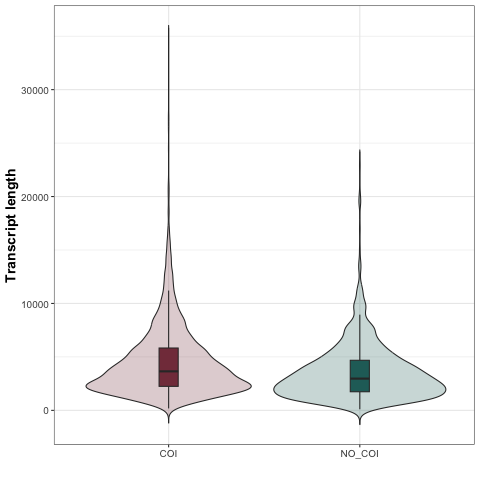

In [120]:
%%R -i genes_tr_len

genes_tr_len <- genes_tr_len[genes_tr_len$Tr_length_inclUTRCDS >= 100, ]
genes_tr_len <-genes_tr_len[genes_tr_len$Tr_length_inclUTRCDS <= 50000, ]

genes_tr_len_plt <- ggplot(na.omit(genes_tr_len[genes_tr_len$Tr_length_inclUTRCDS >= 100, ]), aes(x=FLAG, y=Tr_length_inclUTRCDS, fill=FLAG)) +
geom_violin(alpha=0.25, trim=FALSE) + theme_bw() + theme(axis.text = element_text(size = 10),
                                                                      axis.title =  element_text(size=14,face="bold"), 
                                                        legend.position="none") + #scale_fill_manual(values=c("#3B75E9","#F32737")) +
scale_fill_manual(values=c("#833B49", "#256C68")) +
xlab('') + ylab('Transcript length')

genes_tr_len_plt <- genes_tr_len_plt + geom_boxplot(width=0.1, outlier.shape = NA)

genes_tr_len_plt

#ggsave("./plots/pgenes_tr_len_plt_all.png")

# Number of exons

In [59]:
gene_canonical = search_canonical_transcripts(coi_ensembl, './data/features/canonical_transcripts.txt')

NameError: name 'search_canonical_transcripts' is not defined

In [ ]:
%%R

gff <- read.gff("./data/gencode.v45.annotation.gff3.gz")

exons <- gff %>%
  filter(type == "exon") %>%
  mutate(transcript_id = attributes %>% str_match("transcript_id=(.*?);") %>% .[, 2]) %>%
  select(-attributes)

gene_exon_summary <- exons %>%
  group_by(transcript_id) %>%
  summarise(
    exon_count = n(),
    #exon_spans = paste(start, end, sep = "-", collapse = ";")
  )

gene_exon_summary$transcript_id <- gsub("\\.*","",gene_exon_summary$transcript_id) 

write.table(gene_exon_summary, './data/exons_gencode45.csv', sep='\t', quote=FALSE)

In [71]:
tx_medians[['transcript_id', 'SYMBOL']].to_csv(f'{path_to_temp}/tr_gene.csv', sep='\t', index=False)
tr_symbol_tbl = tx_medians[['transcript_id', 'SYMBOL']]

In [72]:
tr_symbol_tbl.head(2)

,transcript_id,SYMBOL
0,ENST00000000233,ARF5
1,ENST00000000412,M6PR


In [73]:
biomrt_can_tr_len.head(2)

,GeneID,TrID,EnCanonical,Tr_length_inclUTRCDS,SYMBOL
0,ENSG00000210049,ENST00000387314,1.0,71,MT-TF
1,ENSG00000211459,ENST00000389680,1.0,954,MT-RNR1


In [74]:
cantr_symbol_tbl = tr_symbol_tbl.merge(biomrt_can_tr_len, left_on=['transcript_id'], right_on=['TrID'], how="right")
list(cantr_symbol_tbl)

['transcript_id',
 'SYMBOL_x',
 'GeneID',
 'TrID',
 'EnCanonical',
 'Tr_length_inclUTRCDS',
 'SYMBOL_y']

In [75]:
cantr_symbol_tbl = cantr_symbol_tbl[['transcript_id', 'SYMBOL_x']]
cantr_symbol_tbl.columns = ['transcript_id', 'SYMBOL']
cantr_symbol_tbl = cantr_symbol_tbl.dropna()
cantr_symbol_tbl

,transcript_id,SYMBOL
0,ENST00000387314,MT-TF
1,ENST00000389680,MT-RNR1
2,ENST00000387342,MT-TV
3,ENST00000387347,MT-RNR2
4,ENST00000386347,MT-TL1
...,...,...
70743,ENST00000374266,ZNF593
70744,ENST00000361530,CNKSR1
70745,ENST00000447201,ZPLD2P
70750,ENST00000456328,DDX11L1


In [76]:
biomrt_can_tr_len

,GeneID,TrID,EnCanonical,Tr_length_inclUTRCDS,SYMBOL
0,ENSG00000210049,ENST00000387314,1.0,71,MT-TF
1,ENSG00000211459,ENST00000389680,1.0,954,MT-RNR1
2,ENSG00000210077,ENST00000387342,1.0,69,MT-TV
3,ENSG00000210082,ENST00000387347,1.0,1559,MT-RNR2
4,ENSG00000209082,ENST00000386347,1.0,75,MT-TL1
...,...,...,...,...,...
277075,ENSG00000288629,ENST00000676334,1.0,63,NaN
277076,ENSG00000288678,ENST00000679970,1.0,66,NaN
277078,ENSG00000290825,ENST00000456328,1.0,1657,DDX11L2
277079,ENSG00000227232,ENST00000488147,1.0,1380,WASH7P


In [77]:
n_exons = pd.read_csv('./data/features/gencode_v45_exons.csv', sep='\t')

n_exons.columns = ['TrID', 'exon_count']

n_exons

,TrID,exon_count
1,ENST00000000233,6
2,ENST00000000412,7
3,ENST00000000442,7
4,ENST00000001008,10
5,ENST00000001146,6
...,...,...
252926,ENST00000713916,7
252927,ENST00000713917,6
252928,ENST00000713920,8
252929,ENST00000713921,8


In [78]:
n_exons_can= n_exons.merge(biomrt_can_tr_len, on=['TrID'], how='inner')
n_exons_can

,TrID,exon_count,GeneID,EnCanonical,Tr_length_inclUTRCDS,SYMBOL
0,ENST00000000233,6,ENSG00000004059,1.0,1032,ARF5
1,ENST00000000412,7,ENSG00000003056,1.0,2450,M6PR
2,ENST00000000442,7,ENSG00000173153,1.0,2274,ESRRA
3,ENST00000001008,10,ENSG00000004478,1.0,3715,FKBP4
4,ENST00000001146,6,ENSG00000003137,1.0,4556,CYP26B1
...,...,...,...,...,...,...
63182,ENST00000713549,3,ENSG00000285508,1.0,570,NaN
63183,ENST00000713558,1,ENSG00000284934,1.0,135,NaN
63184,ENST00000713560,3,ENSG00000293543,1.0,567,DUSP13A
63185,ENST00000713584,1,ENSG00000282936,1.0,3537,NaN


In [ ]:
# intersect with COI and NO-COI datasets

# All
coi_genes_ex = n_exons_can[n_exons_can['SYMBOL'].isin(coi_genes_list)]
coi_genes_ex['FLAG'] = 'COI'

nocoi_genes_ex = n_exons_can[n_exons_can['SYMBOL'].isin(nocoi_genes_list)]
nocoi_genes_ex['FLAG'] = 'NO_COI'

exon_count = pd.concat([coi_genes_ex, nocoi_genes_ex])


In [79]:
# intersect with COI and NO-COI datasets

# P genes
coi_genes_ex = n_exons_can[n_exons_can['SYMBOL'].isin(coi_pgenes_list)]
coi_genes_ex['FLAG'] = 'COI'

nocoi_genes_ex = n_exons_can[n_exons_can['SYMBOL'].isin(pathogenic_genes_list_nocoi)]
nocoi_genes_ex['FLAG'] = 'NO_COI'

exon_count = pd.concat([coi_genes_ex, nocoi_genes_ex])


/var/folders/sy/0s6mz48x25xdw7n08d30rp5w0000gn/T/ipykernel_7699/3023909197.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coi_genes_ex['FLAG'] = 'COI'
/var/folders/sy/0s6mz48x25xdw7n08d30rp5w0000gn/T/ipykernel_7699/3023909197.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nocoi_genes_ex['FLAG'] = 'NO_COI'


In [80]:
exon_count.to_csv('./plots/exons_pgenes.csv', sep=',', index=False)

In [81]:
# EA genes

ecoi_pgenes_ex = n_exons_can[n_exons_can['SYMBOL'].isin(ea_coi_pgenes_list)]
ecoi_pgenes_ex['FLAG'] = 'E_COI'
print(ecoi_pgenes_ex.shape)

coi_pgenes_ex = n_exons_can[n_exons_can['SYMBOL'].isin(coi_pgenes_list)]
coi_pgenes_ex['FLAG'] = 'COI'
print(coi_pgenes_ex.shape)

# concat
exon_count = pd.concat([ecoi_pgenes_ex,coi_pgenes_ex])

(290, 7)
(3613, 7)


/var/folders/sy/0s6mz48x25xdw7n08d30rp5w0000gn/T/ipykernel_7699/1671862773.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecoi_pgenes_ex['FLAG'] = 'E_COI'
/var/folders/sy/0s6mz48x25xdw7n08d30rp5w0000gn/T/ipykernel_7699/1671862773.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coi_pgenes_ex['FLAG'] = 'COI'


In [82]:
exon_count.to_csv('./plots/exons_ea.csv', sep=',', index=False)

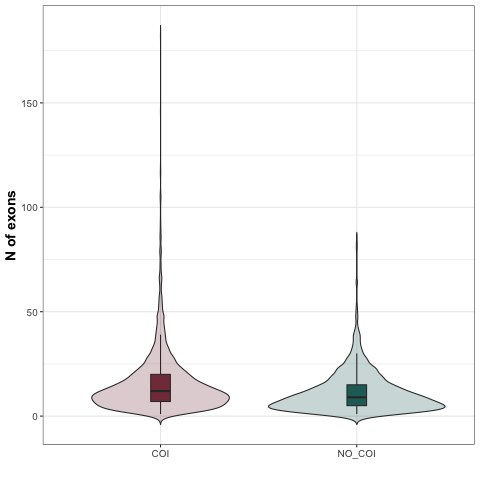

In [121]:
%%R -i exon_count

exon_count_flt <- exon_count[exon_count$exon_count > 0, ]
exon_count_flt <- exon_count_flt[exon_count_flt$exon_count <300, ]

exon_v <- ggplot(exon_count_flt, aes(x=FLAG, y=exon_count, fill=FLAG)) +

geom_violin(alpha=0.25, trim=FALSE) + theme_bw() +
theme(axis.text = element_text(size = 10),
      axis.title =  element_text(size=14, face="bold"), legend.position = "none") + #scale_fill_manual(values=c("#3B75E9","#F32737")) +
scale_fill_manual(values=c("#833B49", "#256C68")) +
xlab('') + ylab('N of exons') 

exon_v <- exon_v + geom_boxplot(width=0.1, outlier.shape = NA)
exon_v

In [119]:
%%R

exon_count <- exon_count[exon_count$exon_count > 0, ]
wilcox.test(exon_count$exon_count[exon_count$FLAG == 'NO_COI'], exon_count$exon_count[exon_count$FLAG == 'COI']) 
#wilcox.test(exon_count$exon_count[exon_count$FLAG == 'COI'], exon_count$exon_count[exon_count$FLAG == 'Enr_COI']) 


	Wilcoxon rank sum test with continuity correction

data:  exon_count$exon_count[exon_count$FLAG == "NO_COI"] and exon_count$exon_count[exon_count$FLAG == "COI"]
W = 1516935, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0

